In [1]:
%load_ext autoreload
%autoreload 2
import torch
import gpytorch
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from gpytorch.constraints import LessThan
from alfi.models.mlp import MLP
from dklfm.transformer_encoder import TransformerEncoder
import yaml
from dklfm.warmup_lr_scheduler import CosineWarmupScheduler
from alfi.utilities.data import create_tx
from dklfm.data.dataset_helpers import load_dataset
from pathlib import Path
from torch.utils.data import DataLoader
import numpy as np
from newdklfm import DKLFM

No module named 'fenics'


In [2]:
# x --> y --> f --> h

In [90]:
# Dataset 
with open(f"./conf/train.yaml") as f:
    train_cfg = yaml.safe_load(f)
    
train_cfg['training']['scale_data'] = True
train_cfg['training']['scale_x_max'] = True
train_cfg['training']['dataset'] = 'reactiondiffusion'
train_cfg['dataset_reactiondiffusion']['n_training_tasks'] = 256+128
train_cfg['dataset_reactiondiffusion']['n_test_tasks'] = 64
synthetic_dataset, real_dataset, scaler_modules = load_dataset(train_cfg)

Path("./newdklfm").mkdir(exist_ok=True)
for obj_name, obj in scaler_modules.items():
    torch.save(obj, Path("./newdklfm") / f'{obj_name}.pt')
    
print("Dataset shapes:")
print(f"-- Output observations: {synthetic_dataset.y.shape}")
print(f"-- Latent observations: {synthetic_dataset.f.shape}")
print(f"-- Inputs observations: {synthetic_dataset.timepoints.shape}")

torch.Size([67200, 2, 1681])
torch.Size([500, 1, 441]) torch.Size([500, 1, 1])
torch.Size([500, 1, 441]) torch.Size([500, 1, 1])
y, f torch.Size([500, 1, 441]) torch.Size([500, 1, 441]) torch.Size([441, 2])
Dataset shapes:
-- Output observations: torch.Size([500, 1, 441])
-- Latent observations: torch.Size([500, 1, 441])
-- Inputs observations: torch.Size([441, 2])


x_cond_blocks shape: torch.Size([32, 441, 2])
x_cond shape: torch.Size([32, 441, 2])
y_cond shape: torch.Size([32, 441])
f_cond shape: torch.Size([32, 441])
21


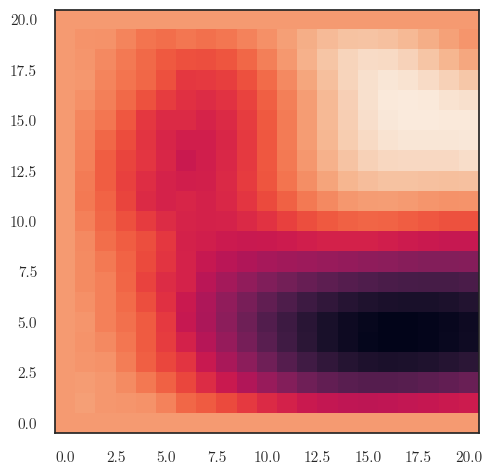

In [112]:
batch_size = 32
loader = DataLoader(synthetic_dataset, batch_size=batch_size, num_workers=12)
val_loader = DataLoader(synthetic_dataset.validation(), batch_size=batch_size, num_workers=12)
batch = next(iter(loader))
x_cond_blocks, x_cond, y_cond, f_cond = batch
print("x_cond_blocks shape:", x_cond_blocks.shape)
print("x_cond shape:", x_cond.shape)
print("y_cond shape:", y_cond.shape)
print("f_cond shape:", f_cond.shape)
i = np.random.randint(0, x_cond.shape[0])
if x_cond.shape[-1] == 1: # Then the data dimension is 1
    num_timepoints = x_cond.shape[1]
    print(num_timepoints)
    y_cond = y_cond.view(batch_size, -1, num_timepoints)
    print(y_cond.shape)
    plt.plot(y_cond[i].t())
else:
    x_width = int(np.sqrt(y_cond.shape[-1]))
    print(x_width)
    plt.imshow(y_cond[i].view(x_width, x_width).t(), origin='lower')

In [145]:
mlp = MLPSkip(1, 1, skip=True)
mlp(torch.randn(1, 1))

[Linear(in_features=1, out_features=32, bias=True), ReLU(), Linear(in_features=32, out_features=32, bias=True), ReLU()]


tensor([[0.0000, 0.0000, 0.0000, 1.0717, 1.2701, 2.7202, 0.5048, 1.1209, 0.0000,
         0.5674, 2.0970, 0.0000, 0.1453, 2.0201, 0.8345, 0.6230, 0.1558, 2.7604,
         2.3369, 0.0000, 0.5434, 0.0000, 0.0000, 0.0173, 0.0000, 3.5829, 2.3959,
         3.9538, 0.0000, 2.3866, 0.0000, 4.2651]], grad_fn=<ReluBackward0>)

In [113]:
from alfi.models import NeuralOperator
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
# We are using the transcriptomics dataset, with 5 functions and 10 timepoints
output_dim = 1
data_dim = x_cond.shape[-1]
embedding_dim = 96

# Embedding over the output observations
# embedder = TransformerEncoder(output_dim, output_dim=embedding_dim, num_hidden_layers=2).type(torch.float64)
modes = 64# 5
width = 32 # 16
deep_kernel_dim = 16
embedder = NeuralOperator(1, 1, embedding_dim, modes, width, params=False)#.type(torch.float64)
# embedder = MLP(data_dim, data_dim, latent_dim=8, num_hidden_layers=3)

# Deep kernel
nn_latent = MLP(data_dim + embedding_dim, deep_kernel_dim, latent_dim=deep_kernel_dim, num_hidden_layers=0).type(torch.float64)
nn_output = MLP(data_dim + embedding_dim, deep_kernel_dim, latent_dim=deep_kernel_dim, num_hidden_layers=0).type(torch.float64)
nn_common = MLP(deep_kernel_dim, 32, latent_dim=deep_kernel_dim, num_hidden_layers=4).type(torch.float64)
dklfm = DKLFM(embedder, [nn_common, nn_latent, nn_output], add_inputs=2)

logger = TensorBoardLogger(Path("./newdklfm").parent / "tb_logs", name="dklfm")
checkpoint_monitor = 'val_loss'
patience = 1200

ckpt_path = "./tb_logs/dklfm/version_69/checkpoints/last.ckpt"
trainer = pl.Trainer(
    accelerator='cuda',
    log_every_n_steps=10,
    max_epochs=350,
    logger=logger,
    callbacks=[
        ModelCheckpoint(save_top_k=3, monitor=checkpoint_monitor, save_last=True),
        ModelCheckpoint(save_top_k=3, monitor="mse", save_last=True, filename="best_mse"),
        EarlyStopping(monitor=checkpoint_monitor, patience=patience),
        LearningRateMonitor(logging_interval='epoch'),
    ]
)
torch.set_float32_matmul_precision('medium')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor([[0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534,
         0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534,
         0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534,
         0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534]],
       dtype=torch.float64, grad_fn=<AddBackward0>)


In [127]:
float(train_cfg['training']['lr'])

0.0001

In [135]:
ckpt_path = "./tb_logs/dklfm/version_52/checkpoints/epoch=1073-step=10740.ckpt"

trainer.fit_loop.max_epochs = 2000
# trainer.fit(dklfm, loader, val_loader, ckpt_path=ckpt_path)
trainer.fit(dklfm, loader, val_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type           | Params
-------------------------------------------------
0 | embedder      | NeuralOperator | 287 K 
1 | nn_common     | MLP            | 2.4 K 
2 | nn_latent     | MLP            | 2.1 K 
3 | nn_output     | MLP            | 2.1 K 
4 | mean_module   | ConstantMean   | 1     
5 | mean_module_f | ConstantMean   | 1     
6 | covar_module  | ScaleKernel    | 35    
-------------------------------------------------
294 K     Trainable params
0         Non-trainable params
294 K     Total params
1.176     Total estimated model params size (MB)


Epoch 1800: 100%|██████████| 12/12 [00:02<00:00,  4.50it/s, v_num=65]      
Validation: 0it [00:00, ?it/s]
Epoch 1801: 100%|██████████| 12/12 [00:02<00:00,  4.34it/s, v_num=65] 
Validation: 0it [00:00, ?it/s]
Epoch 1802: 100%|██████████| 12/12 [00:02<00:00,  4.46it/s, v_num=65] 
Validation: 0it [00:00, ?it/s]
Epoch 1803: 100%|██████████| 12/12 [00:02<00:00,  4.46it/s, v_num=65] 
Validation: 0it [00:00, ?it/s]
Epoch 1804: 100%|██████████| 12/12 [00:02<00:00,  4.37it/s, v_num=65] 
Validation: 0it [00:00, ?it/s]
Epoch 1805: 100%|██████████| 12/12 [00:02<00:00,  4.39it/s, v_num=65] 
Validation: 0it [00:00, ?it/s]
Epoch 1806: 100%|██████████| 12/12 [00:02<00:00,  4.34it/s, v_num=65] 
Validation: 0it [00:00, ?it/s]
Epoch 1807: 100%|██████████| 12/12 [00:02<00:00,  4.50it/s, v_num=65] 
Validation: 0it [00:00, ?it/s]
Epoch 1808: 100%|██████████| 12/12 [00:02<00:00,  4.35it/s, v_num=65] 
Validation: 0it [00:00, ?it/s]
Epoch 1809: 100%|██████████| 12/12 [00:02<00:00,  4.42it/s, v_num=65] 
Valida

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 12/12 [00:03<00:00,  3.15it/s, v_num=65]


In [59]:
ckpt_path = "./tb_logs/dklfm/version_52/checkpoints/epoch=1073-step=10740.ckpt"
# Load from checkpoint
dklfm = DKLFM.load_from_checkpoint(ckpt_path, embedder=embedder, nns=[nn_common, nn_latent, nn_output])



tensor([[0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534,
         0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534,
         0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534, 0.1534,
         0.1534, 0.1534, 0.1534, 0.1534, 0.1534]], dtype=torch.float64,
       grad_fn=<AddBackward0>)


torch.Size([32, 441])
Latent MSE: tensor(0.6176, dtype=torch.float64, grad_fn=<MeanBackward0>)
Output MSE: tensor(7.8036e-08, dtype=torch.float64)
Latent MSE: tensor(0.5220, dtype=torch.float64, grad_fn=<MeanBackward0>)
Output MSE: tensor(2.4135e-06, dtype=torch.float64)


<Figure size 800x550 with 0 Axes>

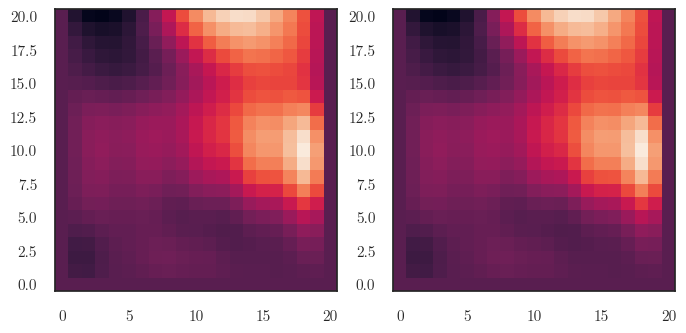

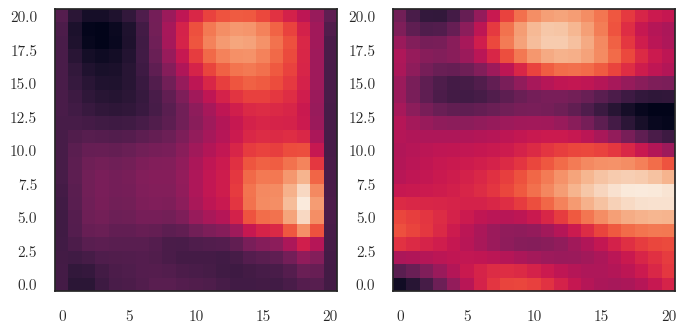

In [148]:
batch = [b.to(dklfm.device) for b in batch]

mu_f_y, k_f_y, _, _ = dklfm.f_given_y(batch)
# mu_y_f, k_y_f = dklfm.y_given_f(batch)
mu_f_y = mu_f_y.cpu()
k_f_y = k_f_y.cpu()
# print(mu_y_f.shape)
mu_y = dklfm.ystar_given_y(batch, batch[1]).cpu()
plt.figure()
x_cond_blocks, x_cond, y_cond, f_cond = [b.cpu() for b in batch]

# plt.plot(mu_y_f[0].view(9, 5)[:, 0].detach())
mu_y = mu_y.reshape(y_cond.shape).detach()

i = np.random.randint(0, mu_y.shape[0])

if x_cond.shape[-1] == 1:
    fig, axes = plt.subplots(ncols=2)
    print(mu_y.shape)
    axes[0].plot(mu_y[i].t())
    axes[1].plot(y_cond[i].t())
    
    plt.figure()
    plt.plot(mu_f_y.squeeze()[i].detach())
    plt.plot(f_cond[i])
else:
    fig, axes = plt.subplots(ncols=2)
    # axes[0].imshow(mu_y_f[4].view(x_width, x_width).detach(), origin='lower')
    axes[0].imshow(mu_y[i].view(x_width, x_width).detach(), origin='lower')
    axes[1].imshow(y_cond[i].view(x_width, x_width), origin='lower')
    
    fig, axes = plt.subplots(ncols=2)
    axes[0].imshow(mu_f_y.squeeze()[i].view(x_width, x_width).detach(), origin='lower')
    axes[1].imshow(f_cond[i].view(x_width, x_width), origin='lower')
    print(f_cond.shape)
    print("Latent MSE:", torch.square(f_cond[i] - mu_f_y.squeeze()[i]).mean())
    print("Output MSE:", torch.square(y_cond[i] - mu_y.squeeze()[i]).mean())
    print("Latent MSE:", torch.square(f_cond - mu_f_y.squeeze()).mean())
    print("Output MSE:", torch.square(y_cond - mu_y.squeeze()).mean())
    
